# Steered Variational AutoEncoder

**Note: if such a method already exists under a different name, I am simply not aware of it**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from steered import SteeredVAE

### Generate data

In [29]:
size = 100000
d = 8

center = np.random.randint(1,d-1,size=(size,2))
height = np.random.randint(1,d//2-1,size=size)
width =  np.random.randint(1,d//2-1,size=size)

X = np.zeros((size,d,d),dtype=int)
y = np.zeros((size,4))

# paint rectangles
for i in range (len(X)):
    left = min(max(center[i,0]-width[i]//2,0),d-1)
    right = min(max(center[i,0]+width[i]//2,0),d-1)
    top = min(max(center[i,1]+height[i]//2,0),d-1)
    bottom = min(max(center[i,1]-height[i]//2,0),d-1)
    # fix single lines
    if abs(left-right) < 3:
        if (left>0):
            left-=1
        if (right<d-1):
            right+=1
    if abs(bottom-top) < 3:
        if (bottom>0):
            bottom-=1
        if (top<d-1):
            top+=1
    X[i,top,left:right+1] = 1
    X[i,bottom,left:right] = 1
    X[i,bottom:top,left] = 1
    X[i,bottom:top,right] = 1
    y[i,0] = abs(top-bottom)+1
    y[i,1] = abs(left-right)+1
    y[i,2] = (top+bottom)/2
    y[i,3] = (left+right)/2

# normalize m
y_m = y.mean(axis=0)
y_s = y.std(axis=0)
y = (y-y_m)/y_s

**Note: y labels MUST be normalized and standarized, because the latent space is a normal distribution**

[4.  3.  5.5 2. ]


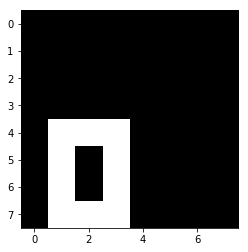

In [30]:
i = np.random.choice(range(len(X)))
print(y[i]*y_s+y_m)
plt.imshow(X[i],cmap='gray')
plt.show()

In [31]:
# flatten
X = X.reshape(size,-1)
X.shape, y.shape

((100000, 64), (100000, 4))

### Generate and train encoder

In [11]:
# steer 4 features (x,y position height and width)
vae = SteeredVAE(64, [24,4],4)

In [32]:
vae.steer(X,y,epochs=5)

Epoch: 1
Cost: -910506.6416625977 1246.45086145401
Epoch: 2
Cost: -912429.8784179688 1242.2454152107239
Epoch: 3
Cost: -913253.5433654785 1238.9601491689682
Epoch: 4
Cost: -913029.6405639648 1233.9455044269562
Epoch: 5
Cost: -914780.787109375 1229.950330466032


Costs are ELBO and L2-loss

### Reconstruction

[ 1.29882948 -0.93274969  0.30917273  0.31487155]
[0.09622589 1.4303287  0.02610569 0.626733  ]


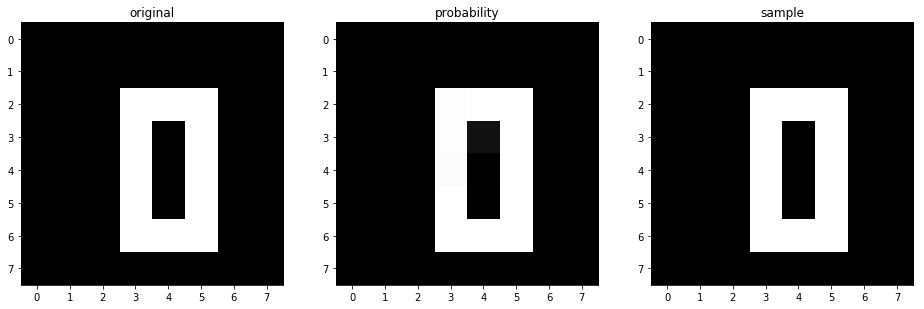

In [33]:
fig,axes = plt.subplots(ncols=3,figsize=(16,16))

i = np.random.choice(len(X))
aa,mm = vae.predict(X[i:i+3])
a = aa[0].reshape(d,d)
b = vae.predict(X[i],'sample')[0].reshape(d,d)

print(y[i])
print(mm[0])

axes[0].imshow(X[i].reshape(d,d),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('probability')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('sample')
plt.show()

### Observe latent space

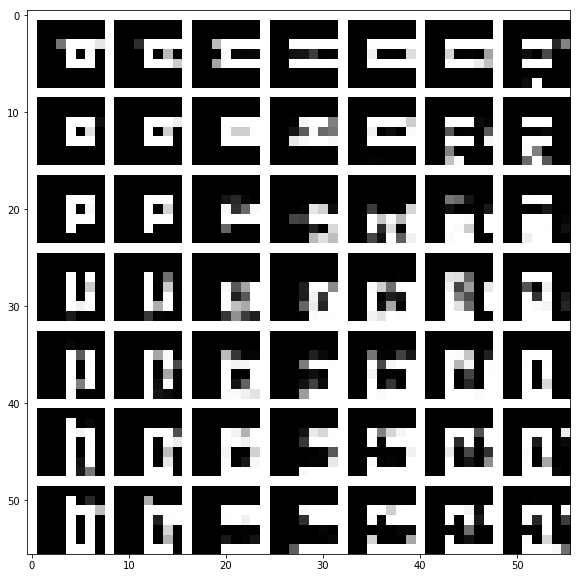

In [35]:
grid = 7
xs = np.linspace(-2, 2, grid)
ys = np.linspace(-2, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([y,x,1,1])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for xx in range(grid):
    for yy in range(grid):
        idx = xx+yy*grid
        current = g[idx].reshape(d,d)
        latent[xx*d:(xx+1)*d,yy*d:(yy+1)*d] = current
        latent[xx*d,:] = 1
        latent[:,yy*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

Overall, features 0 and 1 dicate the width and height, as trained

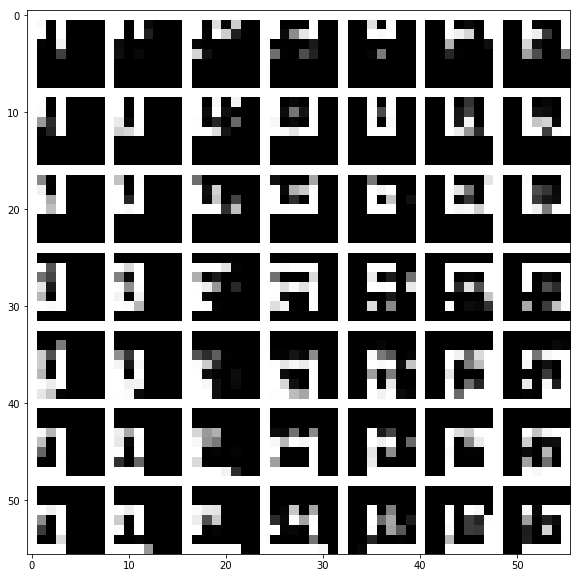

In [36]:
grid = 7
xs = np.linspace(-2, 2, grid)
ys = np.linspace(-2, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([1,1,y,x])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

Indeed, position is mostly dictated by latent features 2 and 3, as trained